In [149]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import statsmodels.formula.api as sm
import copy

## Calculation of Alpha and Beta for CAPM

In [105]:
def getdf(path,ticker):
    df = pd.read_excel(path,ticker)
    df['date'] = pd.to_datetime(df['date'],format = '%Y%m')
    df = df.set_index('date')
    return df

def getfama(path):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'],format = '%Y%m')
    df = df.set_index('date')
    return df

l = ['GM','MSFT','KO']
regression_analysis = {}

df_fama = getfama('Monthly_Fama.csv')

for ticker in l:
    df = getdf("Stocks.xlsx",ticker)
    intersection = df_fama.index.intersection(df.index)
    df_stock = df.loc[intersection,:].copy()
    df_fama_modified = df_fama.loc[intersection,:].copy()
    df_stock['excess_ret'] = df_stock['ret'] - df_fama_modified['RF']
    df_stock['excess_mkt'] = df_fama_modified['Mkt-RF']
    result = sm.ols(formula="excess_ret ~ excess_mkt",data = df_stock).fit()
    regression_analysis[ticker] = []
    regression_analysis[ticker].append(result.params.Intercept)
    regression_analysis[ticker].append(result.params.excess_mkt)

## Summarisation of results

In [101]:
pd.DataFrame.from_dict(regression_analysis, orient='index',columns = ['Alpha','Beta'])

,Alpha,Beta
GM,-0.051211,0.015640
MSFT,-0.227043,0.014091
KO,-0.357885,0.011900


## Test for CAPM

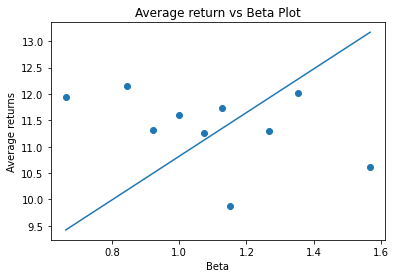

In [153]:
def getPortfolio(path):
    df = pd.read_csv('Monthly_Portfolio_returns.csv')
    df['date'] = pd.to_datetime(df['date'],format='%Y%m')
    df = df.set_index('date')
    df = df.drop(['Lo 20', 'Qnt 2', 'Qnt 3', 'Qnt 4', 'Hi 20'],axis = 1)
    df = df.rename(columns = {"Lo 10":'dec_1',"Dec-02":'dec_2',"Dec-03":'dec_3',"Dec-04":'dec_4',
                            "Dec-05":'dec_5',"Dec-06":'dec_6',"Dec-07":'dec_7',"Dec-08":'dec_8',
                            "Dec-09":'dec_9',"Hi 10":'dec_10'})

    df[df==-99.99] = np.nan
    df[df==-999] = np.nan
    return df

def getbetas(df_portfolio):
    beta_dict = {}
    for col in df_portfolio:
        if(col=='excess_mkt'):
            continue
        reg = sm.ols(formula = str(col) + '~ excess_mkt',data = df_portfolio).fit()
        beta_dict[col] = reg.params.excess_mkt
    return beta_dict 

def getPlots(df_portfolio,df_fama_all,start_date, end_date):
    df_portfolio = df_portfolio.copy().loc[(df_portfolio.index>=start_date) & (df_portfolio.index<=end_date),:]
    df_fama_all = df_fama_all.loc[df_portfolio.index,:]
    avg_rf = df_fama_all['RF'].mean()
    assert df_fama_all.shape[0] == df_portfolio.shape[0] 
    df_portfolio['excess_mkt'] = df_fama_all['Mkt-RF']

    mean_monthly_returns = df_portfolio.mean(axis=0).to_dict()
    beta_dict = getbetas(df_portfolio)

    avg_market_premium = mean_monthly_returns['excess_mkt']

    l_betas = []
    l_mean_returns = []

    for decile in beta_dict:
        l_betas.append(beta_dict[decile])
        l_mean_returns.append(12*mean_monthly_returns[decile])

    l_expected_returns = [12*(avg_market_premium*x + avg_rf)  for x in l_betas]

    assert len(l_betas) == len(l_expected_returns)

    plt.scatter(l_betas,l_mean_returns)
    plt.plot(l_betas,l_expected_returns)
    plt.xlabel('Beta')
    plt.ylabel('Average returns')
    plt.title('Average return vs Beta Plot')

df_portfolio_global = getPortfolio("Monthly_Portfolio_returns.csv")
df_fama_global = getfama('Monthly_Fama.csv')


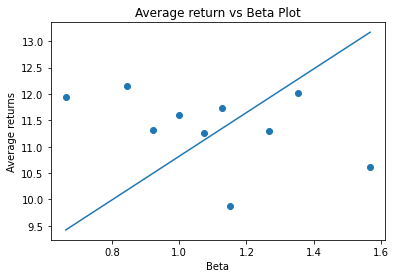

In [154]:
start_date = '1963-07-01'
end_date   = '1990-12-01'
getPlots(copy.deepcopy(df_portfolio_global),copy.deepcopy(df_fama_global),start_date, end_date)

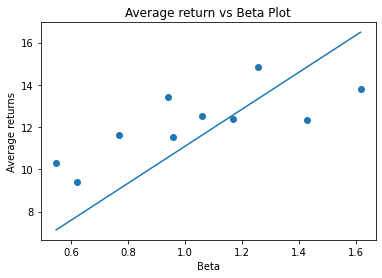

In [155]:
start_date = '1991-01-01'
end_date   = '2022-06-01'
getPlots(copy.deepcopy(df_portfolio_global),copy.deepcopy(df_fama_global),start_date, end_date)